# 1.Import Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime as dt
from pandas.plotting import lag_plot
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import itertools

# 2.Import Datset

In [3]:
cocacola=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
cocacola.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


# 3.Data Understanding

In [4]:
cocacola.shape

(42, 2)

In [5]:
cocacola.dtypes

Quarter     object
Sales      float64
dtype: object

In [6]:
cocacola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [124]:
airline.isna().sum()

Month         0
Passengers    0
dtype: int64

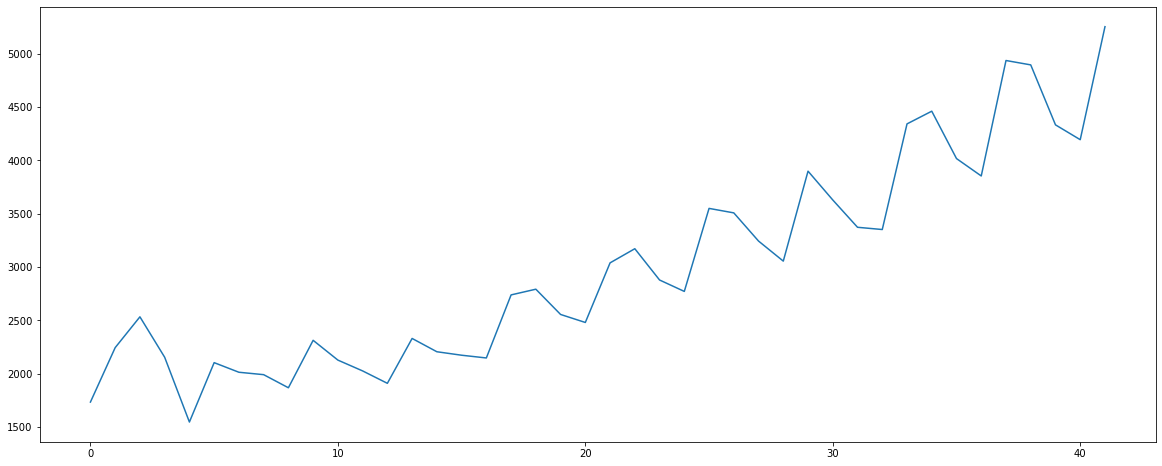

In [7]:
plt.figure(figsize=(20,8))
cocacola['Sales'].plot()
plt.show()

#### Here we can see the nature of data is upward trend 

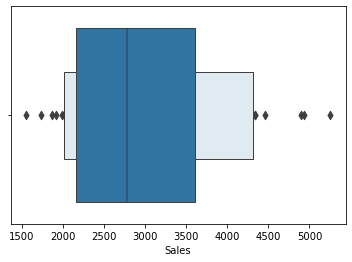

In [8]:
sns.boxenplot(cocacola['Sales'])
plt.show()

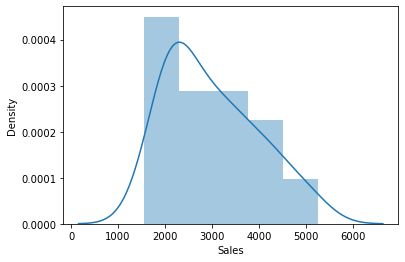

In [9]:
sns.distplot(cocacola['Sales'])
plt.show()

# 4.Data Preprocessing

In [14]:
quarter =['Q1','Q2','Q3','Q4']
p = cocacola["Quarter"][0]
#p[0:2]
cocacola['quarter']= 0

for i in range(42):
    p = cocacola["Quarter"][i]
    cocacola['quarter'][i]= p[0:2]

cocacola.head()

,Quarter,Sales,quarter
0,Q1_86,1734.827000,Q1
1,Q2_86,2244.960999,Q2
2,Q3_86,2533.804993,Q3
3,Q4_86,2154.962997,Q4
4,Q1_87,1547.818996,Q1


#### Getting Dummies for Month

In [16]:
dummies=pd.DataFrame(pd.get_dummies(cocacola['quarter']))
cococola1=pd.concat([cocacola,dummies],axis=1)
cococola1.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1,1,0,0,0


In [21]:
cococola1["t"] = np.arange(0,42)
cococola1["t_squared"] = cococola1["t"]*cococola1["t"]
cococola1["log_Sales"] = np.log(cococola1['Sales'])
cococola1.columns
cococola1.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4,t,t_squared,log_Sales
0,Q1_86,1734.827000,Q1,1,0,0,0,0,0,7.458663
1,Q2_86,2244.960999,Q2,0,1,0,0,1,1,7.716443
2,Q3_86,2533.804993,Q3,0,0,1,0,2,4,7.837477
3,Q4_86,2154.962997,Q4,0,0,0,1,3,9,7.675529
4,Q1_87,1547.818996,Q1,1,0,0,0,4,16,7.344602


<AxesSubplot:xlabel='quarter', ylabel='Sales'>

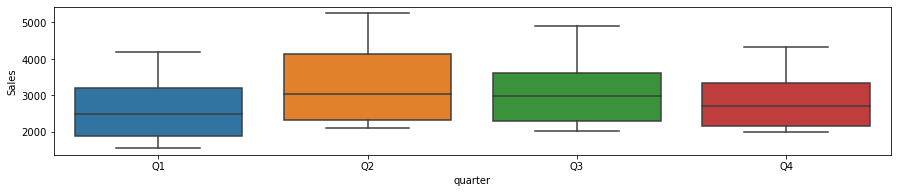

In [24]:
plt.figure(figsize=(15,6))
plt.subplot(211)
sns.boxplot(x="quarter",y="Sales",data=cococola1)

<AxesSubplot:xlabel='quarter', ylabel='Sales'>

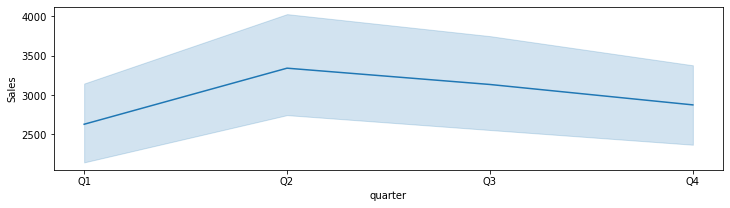

In [25]:
plt.figure(figsize=(12,3))
sns.lineplot(x="quarter",y="Sales",data=cococola1)

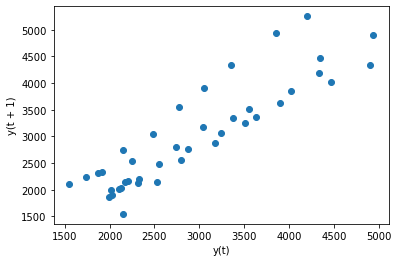

In [26]:
lag_plot(cococola1['Sales'])
plt.show()

# ACF abd PACF plot

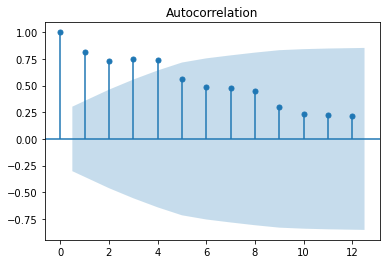

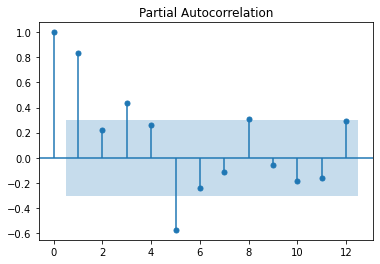

In [27]:
tsa_plots.plot_acf(cococola1.Sales,lags=12)
tsa_plots.plot_pacf(cococola1.Sales,lags=12)
plt.show()

# Time series decomposition plot

<Figure size 2160x720 with 0 Axes>

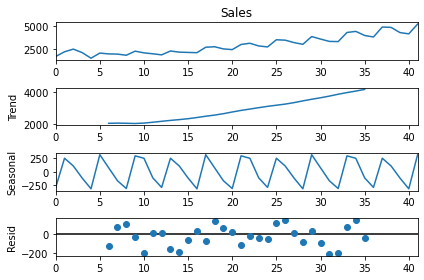

In [28]:
decompose_ts_add = seasonal_decompose(cococola1['Sales'],period=12)
plt.figure(figsize=(30,10))
decompose_ts_add.plot()
plt.show()

#### We have seen decomposition to see how trend and seasonality affecting data

### Splitting data into train and test 

In [30]:
Train = cococola1.head(75)
Test = cococola1.tail(25)

# 5.Model Building

# 5.1 Model Based Forecasting

## 5.1.1 Linear Model

In [32]:
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  375.15827820152924


## 5.1.2 Exponential model

In [33]:
Exp = smf.ols('log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  344.66576991020526


## 5.1.3 Quadratic

In [34]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  337.1164381991828


## 5.1.4 Additive seasonality

In [35]:
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1','Q2','Q3','Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  937.7710121110202


## 5.1.5 Additive Seasonality Quadratic

In [36]:
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1','Q2','Q3','Q4','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 137.30486583146669


## 5.1.6 Multiplicative Seasonality

In [37]:
Mul_sea = smf.ols('log_Sales~Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 1031.5813830617249


## 5.1.7 Multiplicative Additive Seasonality

In [38]:
Mul_Add_sea = smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea )

RMSE Multiplicative Additive Seasonality: 129.11388431790675


# 5.2 Data driven Forecasting

## 5.2.1 Moving Average

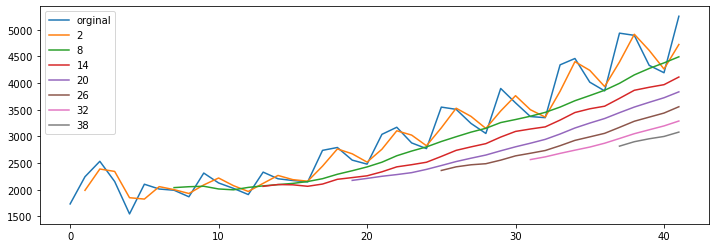

In [39]:
plt.figure(figsize=(12,4))
cococola1['Sales'].plot(label="orginal")
for i in range(2,43,6):
    cococola1['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

In [40]:
cococola1['Sales'].rolling(2).mean()

0             NaN
1     1989.893999
2     2389.382996
3     2344.383995
4     1851.390997
5     1826.115496
6     2059.387497
7     2003.054998
8     1930.398499
9     2091.340998
10    2220.975998
11    2077.574499
12    1968.716497
13    2120.884495
14    2268.857494
15    2190.258995
16    2161.122997
17    2443.792999
18    2766.030998
19    2674.381996
20    2518.491997
21    2760.248497
22    3105.819496
23    3025.558498
24    2825.500500
25    3161.000000
26    3529.000000
27    3375.929996
28    3149.929996
29    3477.500000
30    3764.000000
31    3501.000000
32    3362.500000
33    3847.000000
34    4401.500000
35    4239.000000
36    3935.500000
37    4395.000000
38    4915.500000
39    4614.000000
40    4263.500000
41    4723.500000
Name: Sales, dtype: float64

## 5.2.2 Simple Exponential Smoothing model

In [41]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])

ses_rms=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_ses))**2))
ses_rms

590.0455965998023

## 5.2.3 Holt model 

In [42]:
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2) # two levels of smoothening
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
hw_rms=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_hw))**2))
hw_rms

513.5266447117874

## 5.2.4 Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [43]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])

hw_ma_rms=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_hwe_mul_add))**2))
hw_ma_rms

140.04413727168136

## 5.2.5 Holts winter exponential smoothing with additive seasonality and multiplicative trend

In [44]:
hwe_model_add_mul= ExponentialSmoothing(Train["Sales"],seasonal="add",trend="mul",seasonal_periods=12).fit() 
pred_hwe_add_mul = hwe_model_add_mul.predict(start = Test.index[0],end = Test.index[-1])

hw_am_rms=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_hwe_add_mul))**2))
hw_am_rms

201.55629644760586

## 5.2.6 Holts winter exponential smoothing with additive seasonality and additive trend

In [45]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])

hw_aa_rms=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_hwe_add_add))**2))
hw_aa_rms

202.21059151046498

## 5.2.7 ARMA Model

In [46]:
ARMAmodel = ARMA(Train['Sales'], order=(3, 0)) #model with AR=1 and MA=0
ARMAmodel_fit = ARMAmodel.fit()

ARMA_pred = ARMAmodel_fit.predict(start = Test.index[0],end = Test.index[-1])
ARMA_pred

arma_rms=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(ARMA_pred))**2))
arma_rms

377.33540628600986

## 5.2.7 ARIMA Model

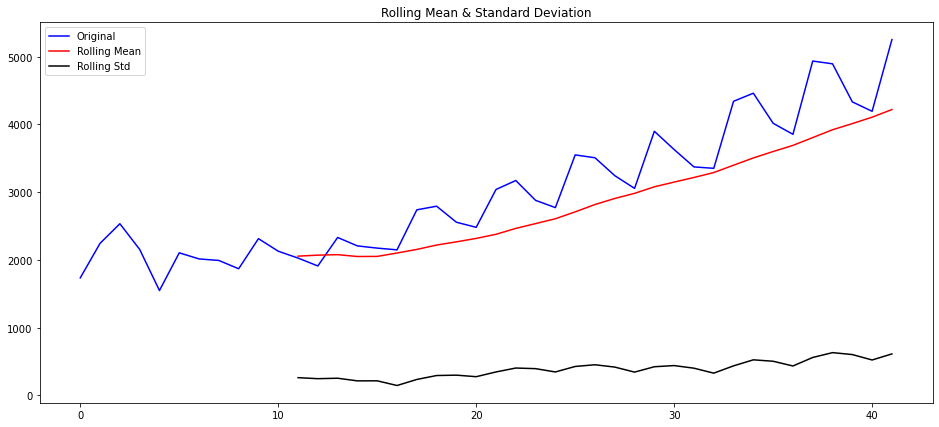

In [47]:
rolLmean = cococola1['Sales'].rolling(12).mean() # 12 entries
rolLstd = cococola1['Sales'].rolling(12).std()

plt.figure(figsize=(16,7))

#Plot rolling statistics:
orig = plt.plot(cococola1['Sales'], color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#### We can see that data is not stationery 

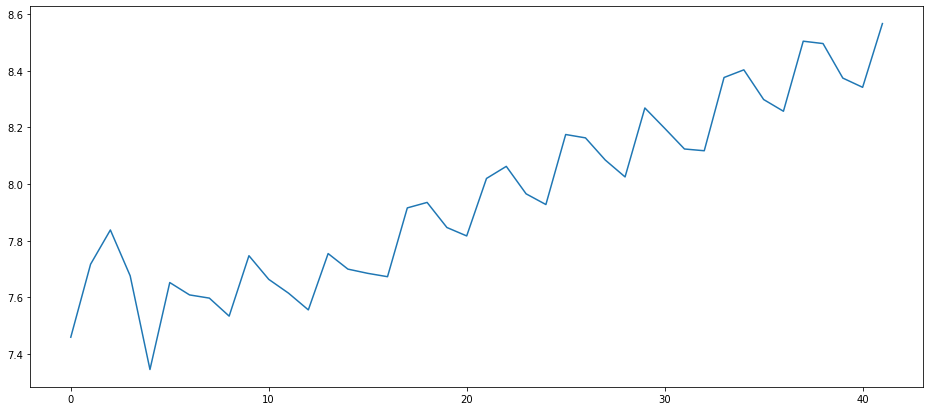

In [48]:
plt.figure(figsize=(16,7))
ts_log = np.log(cococola1['Sales'])#to transform to stationary from non-stationary
plt.plot(ts_log)

### Differencing

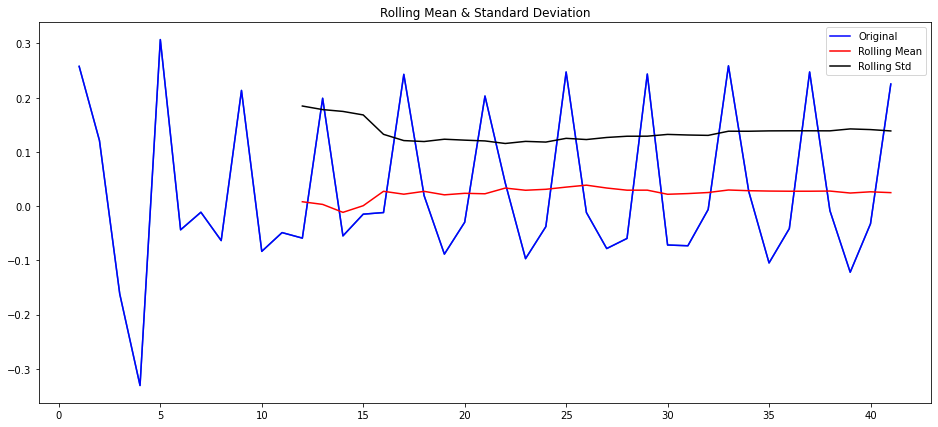

In [49]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift(periods=1) # I will shift the time series by 1 and subtract from the original TS.
plt.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [50]:
lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12)

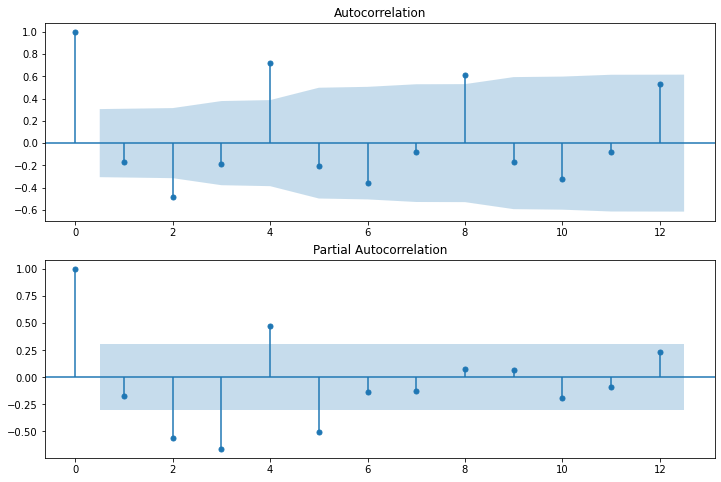

In [51]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=12,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=12,ax=ax2)

In [52]:
p = range(0,5) #AR order
d = range(0,5) #Shift
q = range(0,5) #MA order
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [55]:
for param in pdq:
    try:
        model_arima = ARIMA(Train['Sales'],order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 700.5556163745397
(0, 0, 1) 672.7627369914055
(0, 0, 2) 638.0088346480658
(0, 0, 3) 636.310983407607
(0, 0, 4) 633.6839601182494
(0, 1, 0) 617.614937007783
(0, 1, 1) 607.2777520007756
(0, 1, 2) 606.1629102769843
(0, 1, 3) 600.7282513084782
(0, 1, 4) 580.4028970884854
(0, 2, 0) 633.3976676318601
(0, 2, 1) 608.9435834302571
(0, 2, 2) 593.1930232455967
(0, 2, 3) 618.5524422771575
(0, 2, 4) 588.2527507361699
(1, 0, 0) 637.530198697312
(1, 0, 1) 634.7258712858512
(1, 0, 2) 633.8105572496752
(1, 0, 3) 625.3717169897678
(1, 0, 4) 602.1673566261667
(1, 1, 0) 618.8473071339549
(1, 1, 1) 608.7365920341296
(1, 1, 2) 607.9196281044983
(1, 1, 4) 582.3541746649652
(1, 2, 0) 632.8484101856958
(1, 2, 1) 610.376566195119
(2, 0, 0) 639.2219334695944
(2, 0, 1) 636.2035865971728
(2, 0, 2) 635.6406341345129
(2, 0, 3) 622.8063061084013
(2, 0, 4) 604.1116134718053
(2, 1, 0) 597.8209706418925
(2, 1, 1) 591.3684932079432
(2, 2, 0) 622.1910625022783
(2, 2, 1) 588.8821823043451
(2, 2, 2) 574.8427706309

### (3,2,0) gives least aic value

In [58]:
ARIMAmodel = ARIMA(Train['Sales'], order=(3,2,0)) #notice p,d and q value here
ARIMA_model_fit = ARIMAmodel.fit()

ARIMA_pred = ARIMA_model_fit.predict(start = Test.index[0],end = Test.index[-1])

arima_rms=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(ARMA_pred))**2))
arima_rms

377.33540628600986

In [59]:
data1 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea","ses_model","hw_model","hwe_model_mul_add","hwe_model_add_mul","hwe_model_add_add","ARMAmodel","ARIMAmodel"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea,ses_rms,hw_rms,hw_ma_rms,hw_am_rms,hw_aa_rms,arma_rms,arima_rms])}
table_rmse=pd.DataFrame(data1)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,375.158278
1,rmse_Exp,344.665770
2,rmse_Quad,337.116438
3,rmse_add_sea,937.771012
4,rmse_add_sea_quad,137.304866
5,rmse_Mult_sea,1031.581383
6,rmse_Mult_add_sea,129.113884
7,ses_model,590.045597
8,hw_model,513.526645
9,hwe_model_mul_add,140.044137


### We can clearly see that Multiplicative Additive Seasonality gave less RMSE value